In [68]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from pathlib import Path

In [69]:
cwd = Path.cwd()
print(cwd)

C:\Users\Felix Medicus\Desktop\Thesis_MCC\DuetBenchmarking\Results


In [70]:
filepath = os.path.join(cwd, "Results", "300_000ops", "load_measurements.txt")
print(pathname)

C:\Users\Felix Medicus\Desktop\Thesis_MCC\DuetBenchmarking\Results\Results\300_000ops\load_measurements.dat


In [71]:
df = pd.read_csv(filepath)
print(df.head)

<bound method NDFrame.head of        workerId queryType                               queryId  \
0           w1b    INSERT  81861a34-9bec-48f4-aa40-f3990b0b7d93   
1           w1a    INSERT  81861a34-9bec-48f4-aa40-f3990b0b7d93   
2           w1a    INSERT  8b0d2f47-0509-4e50-ad32-8275cb93735a   
3           w1b    INSERT  8b0d2f47-0509-4e50-ad32-8275cb93735a   
4           w1a    INSERT  bf17828d-476f-432a-ba6d-7b071b0aeeca   
...         ...       ...                                   ...   
599995      w3b    INSERT  8d78a1c4-98c8-4b1a-bddb-0554fd5f7b51   
599996      w3b    INSERT  896e6750-ab76-45fa-b9d5-d36578bf6307   
599997      w3b    INSERT  01583ad9-0fa3-4638-8168-be47129db5a1   
599998      w3b    INSERT  c051e067-1ea3-49c4-8e39-0a0da359ff17   
599999      w3b    INSERT  607837b5-b292-4969-a95c-1d28f2bbab9f   

                 sent       received target-region  
0       1657629638244  1657629638294  europe-west1  
1       1657629638243  1657629638298  europe-west1  
2     

In [72]:
print(df["sent"].max())

1657630041431


In [73]:
df["latency_ms"] = df["received"]- df["sent"]


In [74]:
print(df.head())


  workerId queryType                               queryId           sent  \
0      w1b    INSERT  81861a34-9bec-48f4-aa40-f3990b0b7d93  1657629638244   
1      w1a    INSERT  81861a34-9bec-48f4-aa40-f3990b0b7d93  1657629638243   
2      w1a    INSERT  8b0d2f47-0509-4e50-ad32-8275cb93735a  1657629638298   
3      w1b    INSERT  8b0d2f47-0509-4e50-ad32-8275cb93735a  1657629638296   
4      w1a    INSERT  bf17828d-476f-432a-ba6d-7b071b0aeeca  1657629638301   

        received target-region  latency_ms  
0  1657629638294  europe-west1          50  
1  1657629638298  europe-west1          55  
2  1657629638301  europe-west1           3  
3  1657629638301  europe-west1           5  
4  1657629638305  europe-west1           4  


In [75]:
df["latency_ms"].describe()

count    600000.000000
mean          3.851087
std          15.001065
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max         901.000000
Name: latency_ms, dtype: float64

In [76]:
sns.set_theme(style="darkgrid")


In [77]:
totalTime = df["received"].max() - df["sent"].min()
print(totalTime/1000/60, "minuten")

6.719833333333333 minuten


In [83]:
print(df["sent"].min())

1657629638243


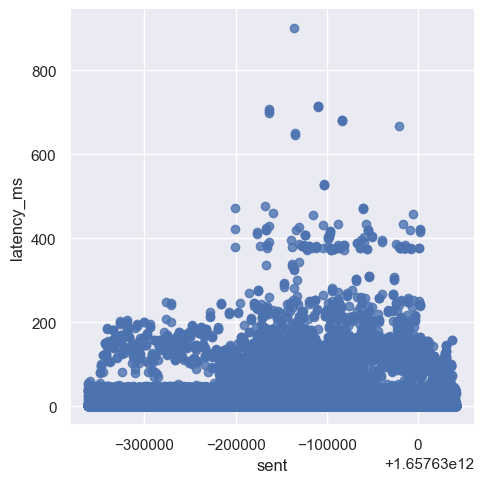

In [84]:
sns.lmplot(x='sent', y='latency_ms', data=df, fit_reg=True)